In [1]:
import sys

import numpy as np
from skimage import filters
from matplotlib import pyplot as plt
import proplot as pplt
from tqdm import tqdm
from tqdm import trange

sys.path.append('../../')
from tools import plotting as myplt
from tools import beam_analysis as ba
from tools import ap_utils
from tools import utils
from measurement.tomography import reconstruct as rec

In [2]:
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['axes.grid'] = False
pplt.rc['grid.alpha'] = 0.04
pplt.rc['cmap.discrete'] = False

Load distribution from Holmes (2018).

In [3]:
X = np.loadtxt('/Users/austin/Dropbox/SCBD/scratch/RUN_0167/data/Bm_Parts_0_300')
X = X[:, :4]
X -= np.mean(X, axis=0)

Normalize the distribution. Use Twiss parameters that are not quite matched to the distribution.

In [4]:
Sigma = np.cov(X.T)
alpha_x, alpha_y, beta_x, beta_y = ba.twiss2D(Sigma)
print(alpha_x, alpha_y, beta_x, beta_y)

np.random.seed(1)
dalpha = 0.15
dbeta = 0.2 * max(beta_x, beta_y)
alpha_x += np.random.uniform(-dalpha, dalpha)
alpha_y += np.random.uniform(-dalpha, dalpha)
beta_x += np.random.uniform(-dbeta, dbeta)
beta_y += np.random.uniform(-dbeta, dbeta)
print(alpha_x, alpha_y, beta_x, beta_y)

0.00273832682072681 0.12530987414556008 22.701313304703437 11.875058582880387
-0.02215507176850098 0.19140722217820752 18.162089227187835 10.08013450335266


In [5]:
V = ap_utils.V_matrix_4x4_uncoupled(alpha_x, alpha_y, beta_x, beta_y)
Vinv = np.linalg.inv(V)
Xn = utils.apply(Vinv, X)

Bin the coordinates at the reconstruction location.

In [11]:
n_bins = 75
cmap = 'mono_r'

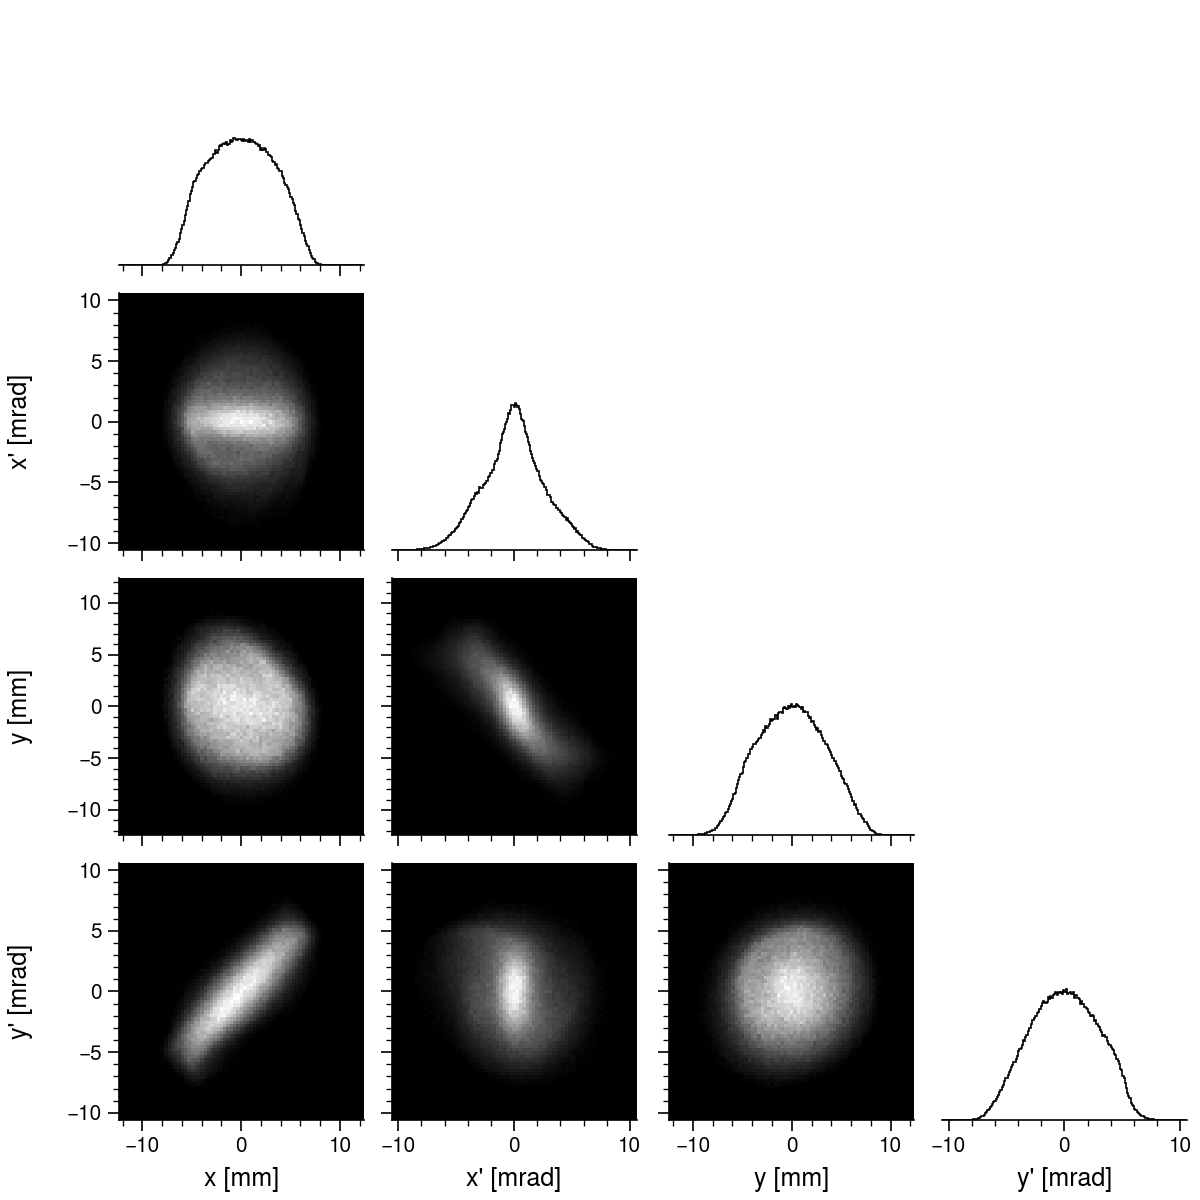

In [12]:
axes = myplt.corner(Xn, figsize=(6, 6), cmap=cmap, bins=n_bins, 
                    autolim_kws=dict(sigma=3.65)
                   )
limits = [ax.get_xlim() for ax in axes[-1, :]]

In [13]:
Z_true, edges = np.histogramdd(Xn, n_bins, limits, density=True)
centers = []
for _edges in edges:
    centers.append(0.5 * (_edges[:-1] + _edges[1:]))
bin_volume = rec.get_bin_volume(limits, n_bins)

Transport the distribution to the screen.

In [40]:
K = 15 # number of angles in x dimension
L = 15 # number of angles in y dimension
muxx = np.linspace(0., np.pi, K, endpoint=False)
muyy = np.linspace(0., np.pi, L, endpoint=False)

xx_list, tmats_x = [], []
for mux in tqdm(muxx):
    Mx = utils.rotation_matrix(mux)
    xx_list.append(utils.apply(Mx, Xn[:, :2])[:, 0])
    tmats_x.append(Mx)

yy_list, tmats_y = [], []
for muy in tqdm(muyy):
    My = utils.rotation_matrix(muy)
    yy_list.append(utils.apply(My, Xn[:, 2:])[:, 0])
    tmats_y.append(My)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:34<00:00,  2.28s/it]


Bin the coordinates on the screen.

In [41]:
sigma = 0.0 # Gaussian blur
S = np.zeros((n_bins, n_bins, K, L))
for k, xx in enumerate(tqdm(xx_list)):
    for l, yy in enumerate(yy_list):
        z, _, _ = np.histogram2d(xx, yy, n_bins, (limits[0], limits[2]))
        z = filters.gaussian(z, sigma)
        S[:, :, k, l] = z

100%|██████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.03s/it]


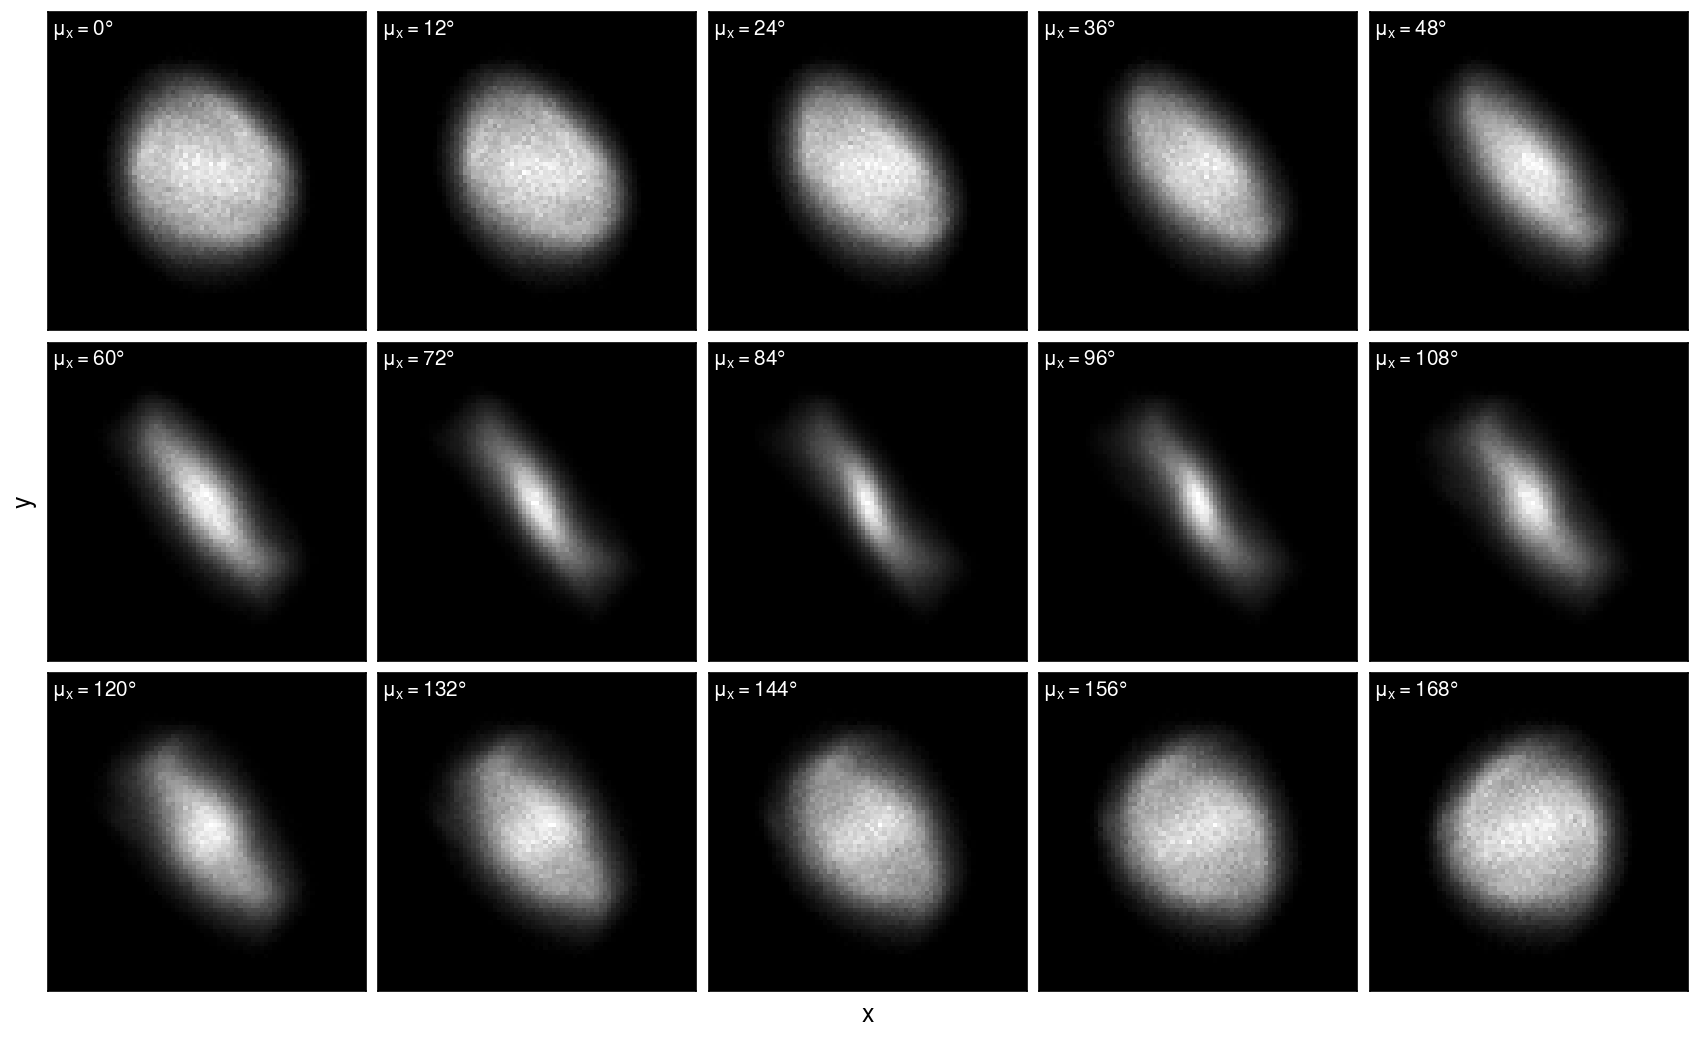

In [42]:
fig, axes = pplt.subplots(nrows=3, ncols=5, figwidth=8.5, space=0.5)
for k, ax in enumerate(axes):
    ax.pcolormesh(centers[0], centers[2], S[:, :, k, 0].T, cmap='mono_r')
    ax.annotate(r'$\mu_x = {:.0f}\degree$'.format(np.degrees(muxx[k])), 
                xy=(0.01, 0.93), xycoords='axes fraction',
                color='white',
                fontsize='small',
               )
axes.format(xlabel="x", ylabel="y", 
            xticks=[], yticks=[],
           )
plt.savefig('_output/tomo_sim_target_scan.png', dpi=350)
plt.show()

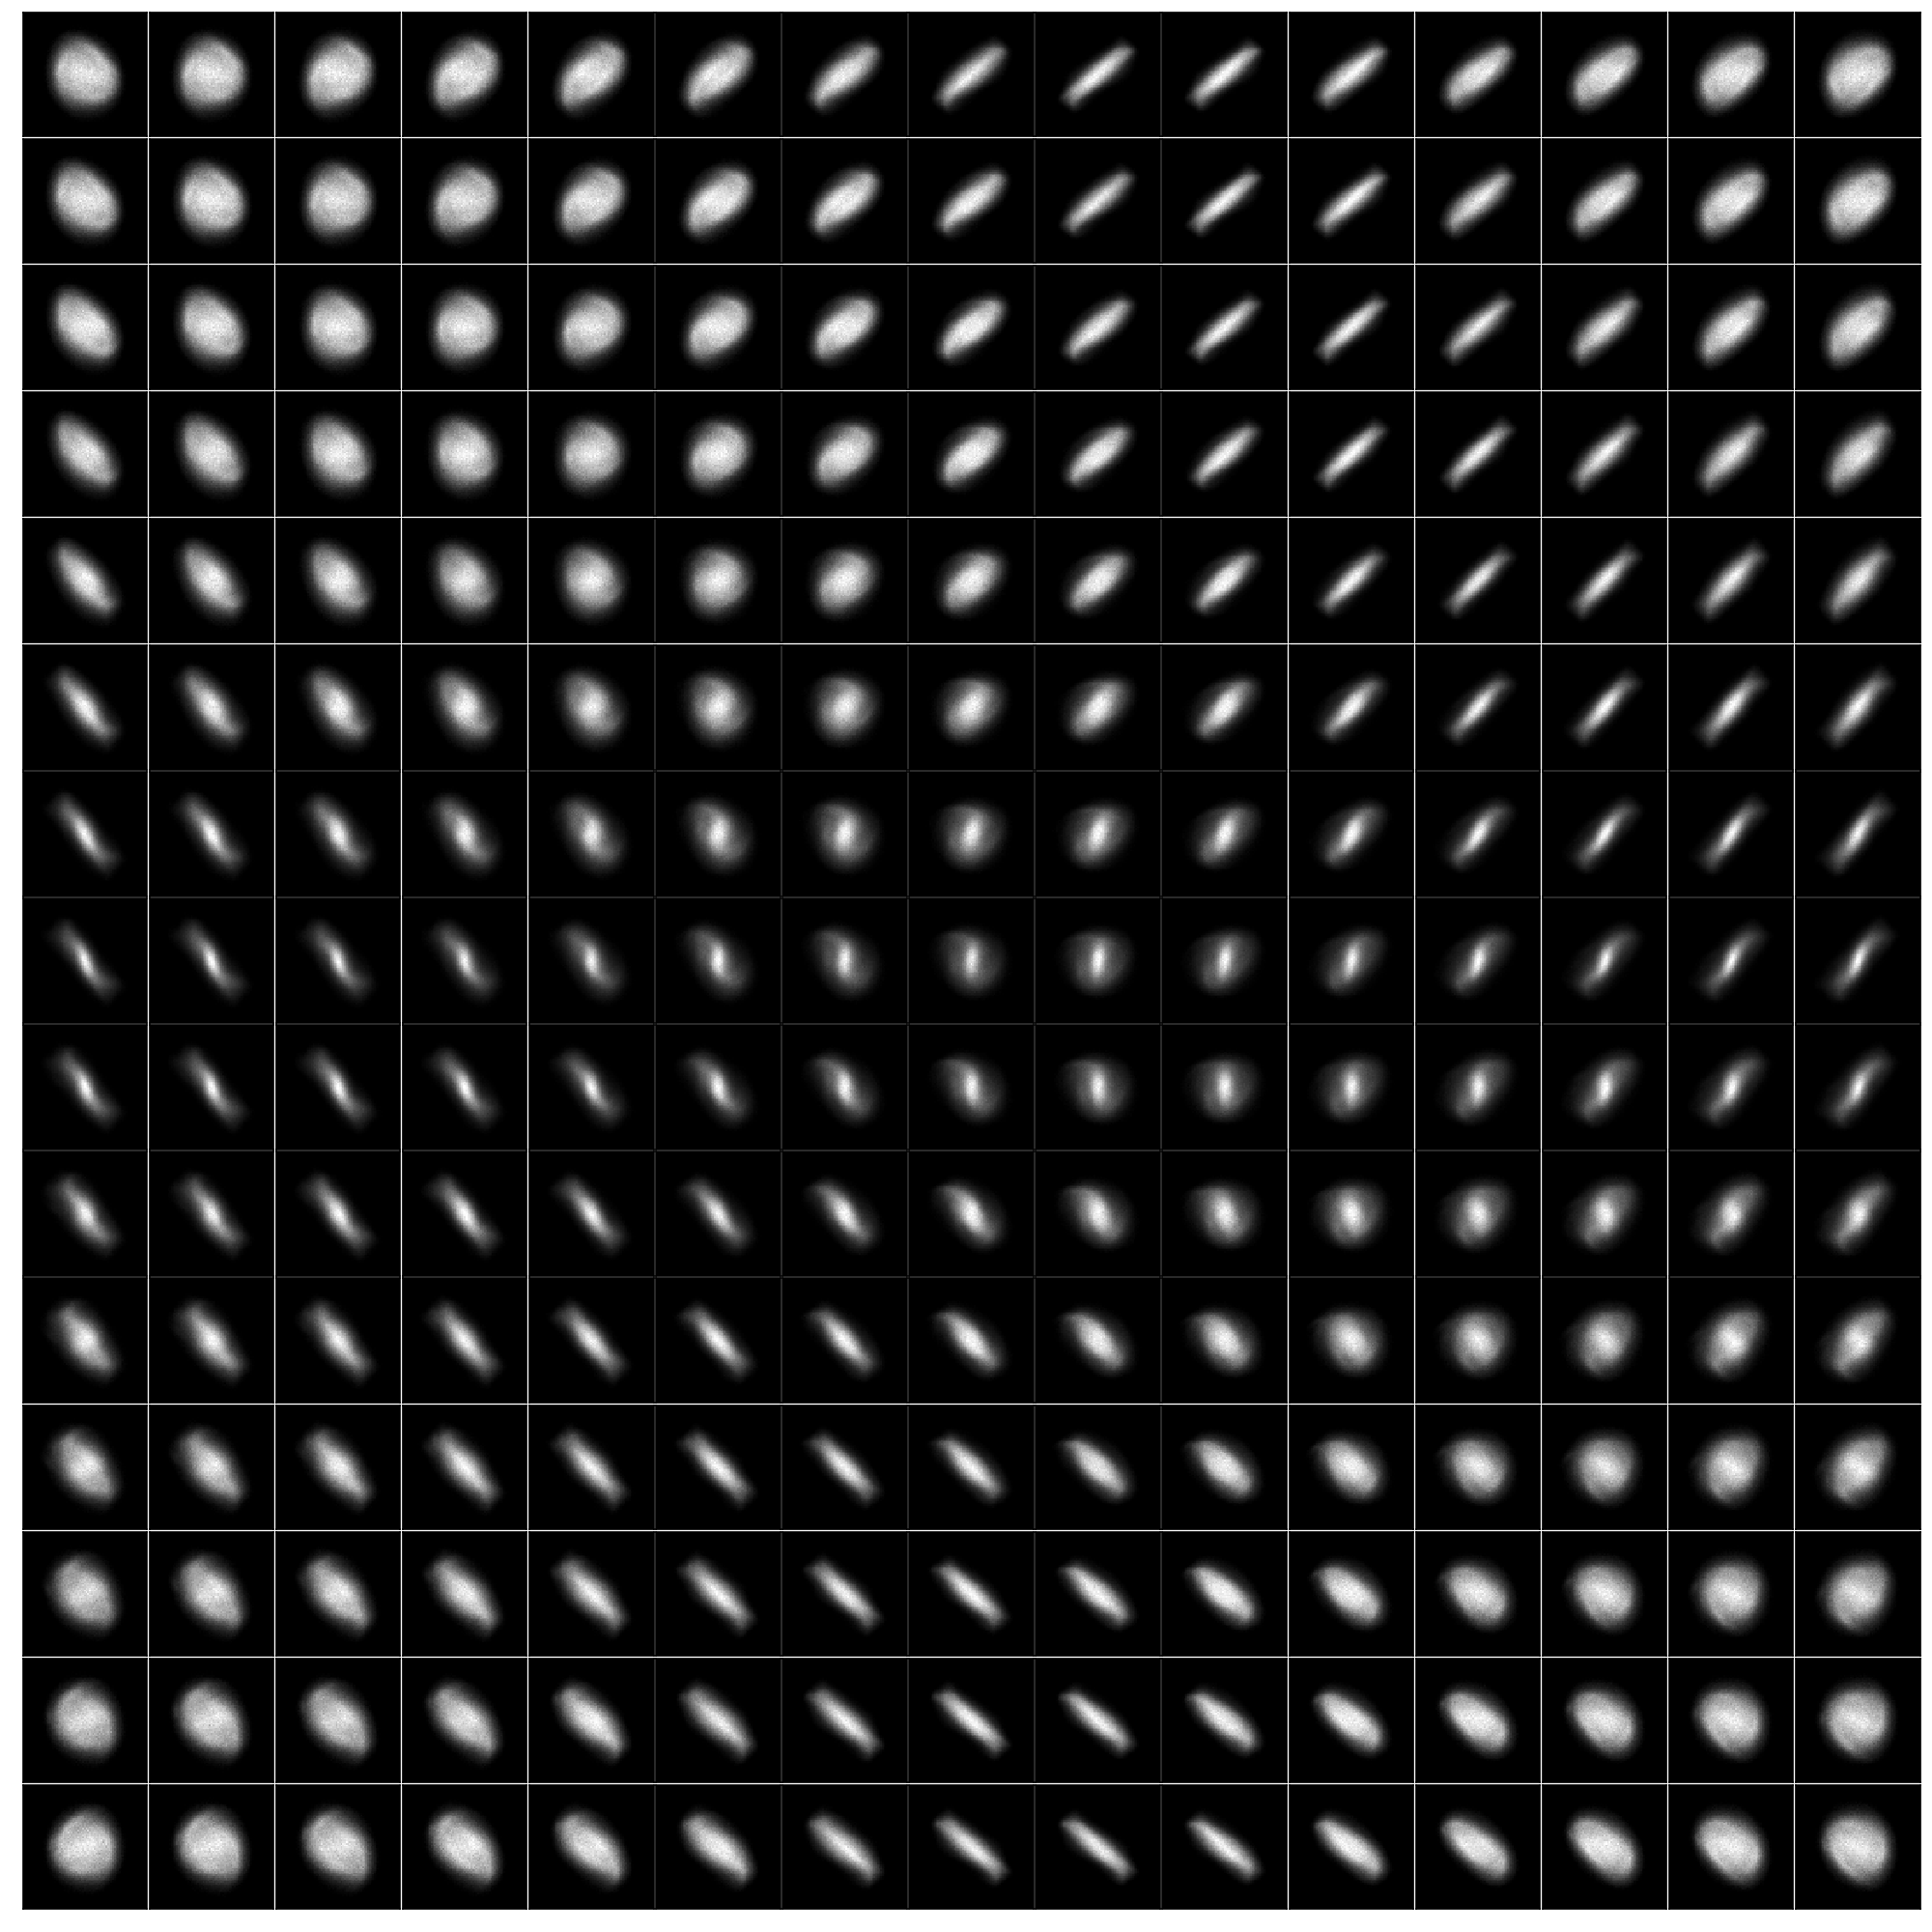

In [58]:
fig, axes = pplt.subplots(nrows=K, ncols=L, figwidth=10, space=0.1)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        ax.pcolormesh(centers[0], centers[2], S[:, :, i, j].T, cmap='mono_r', ec='None')
axes.format(
    xticks=[], yticks=[], 
#     xlabel='x', ylabel='y',
)
plt.savefig('_output/tomo_sim_target_scan_full.png', dpi=500)
plt.show()

## Hock's method

In [59]:
Z_hock = rec.hock4D(S, tmats_x, tmats_y, method='SART', 
                    keep_positive=True, density=True, limits=limits, iterations=2)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 75/75 [01:26<00:00,  1.15s/it]


In [60]:
print('min(Z) = {}'.format(np.min(Z_hock)))
print('max(Z) = {}'.format(np.max(Z_hock)))
print('sum(Z) * bin_volume = {}'.format(np.sum(Z_hock) * bin_volume))
print()
print('min(Z_true) = {}'.format(np.min(Z_true)))
print('max(Z_true) = {}'.format(np.max(Z_true)))
print('sum(Z_true) * bin_volume = {}'.format(np.sum(Z_true) * bin_volume))

min(Z) = 0.0
max(Z) = 0.0007687989669116694
sum(Z) * bin_volume = 1.000000000000002

min(Z_true) = 0.0
max(Z_true) = 0.0021034628399277714
sum(Z_true) * bin_volume = 0.999999999999997


In [61]:
avg_abs_err_per_bin = np.sum(np.abs(Z_hock - Z_true)) / Z_hock.size
print('Average absolute error per bin = {}'.format(avg_abs_err_per_bin))

Average absolute error per bin = 3.597467294230289e-06


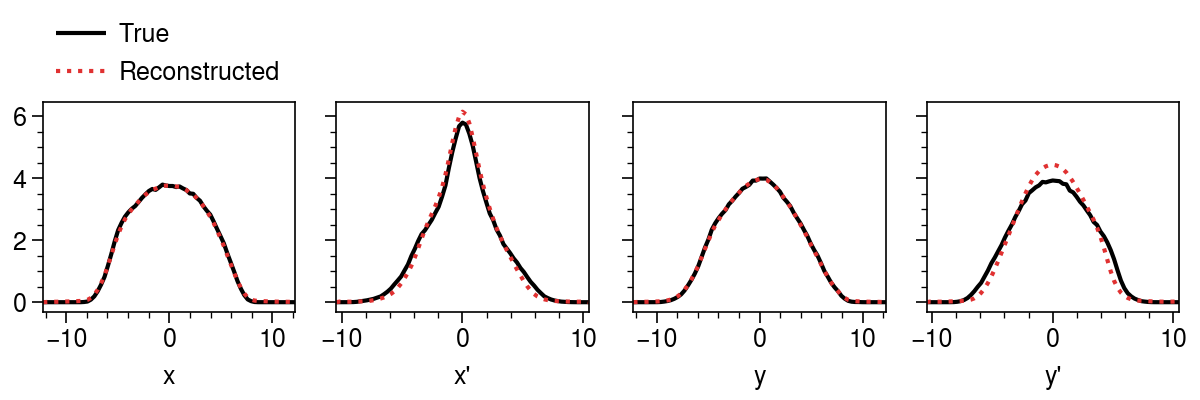

In [62]:
fig, axes = pplt.subplots(ncols=4, figsize=(6, 2), spanx=False)
labels = ["x", "x'", "y", "y'"]
for i in range(4):
    axes[i].plot(centers[i], rec.project(Z_true, i), color='black', label='True')
    axes[i].plot(centers[i], rec.project(Z_hock, i), color='red8', ls='dotted', label='Reconstructed')
    axes[i].set_xlabel(labels[i])
axes[0].legend(loc=(0.0, 1.02), framealpha=0.0, ncol=1);
plt.savefig('_output/tomo_sim_rec_hock_proj_1D.png', dpi=350)
plt.show()

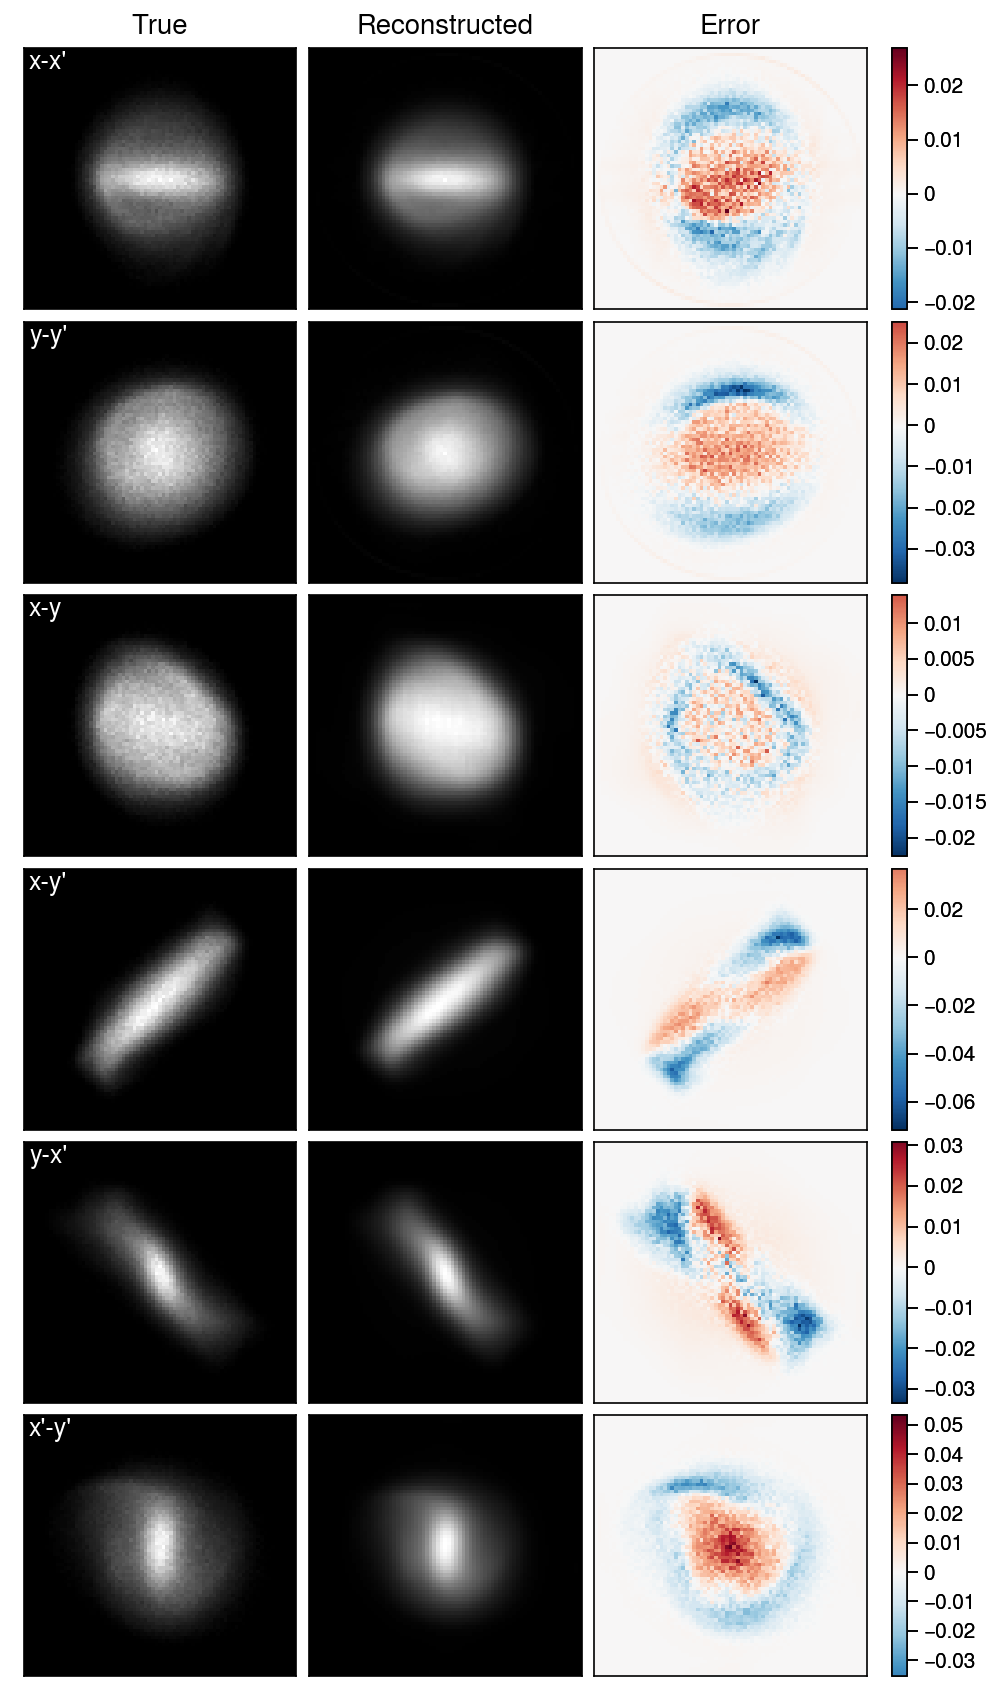

In [73]:
plot_kws = dict(cmap=cmap)
indices = [(0, 1), (2, 3), (0, 2), (0, 3), (2, 1), (1, 3)]
fig, axes = pplt.subplots(nrows=6, ncols=3, figsize=(5.0, 8.5), 
                          sharex=False, sharey=False, space=0.5)
for row, (i, j) in enumerate(indices):
    _Z_true = rec.project(Z_true, [i, j])
    _Z = rec.project(Z_hock, [i, j])
    axes[row, 0].pcolormesh(centers[i], centers[j], _Z_true.T, **plot_kws)
    axes[row, 1].pcolormesh(centers[i], centers[j], _Z.T, **plot_kws)
    axes[row, 2].pcolormesh(centers[i], centers[j], (_Z - _Z_true).T, 
                            colorbar=True, 
                            colorbar_kw=dict(width=0.075, space=1.0, ticklabelsize='small')
                           )
    axes[row, 0].annotate('{}-{}'.format(labels[i], labels[j]),
                          xy=(0.02, 0.92), xycoords='axes fraction', color='white', 
                          fontsize='medium')
for ax, title in zip(axes[0, :], ['True', 'Reconstructed', 'Error']):
    ax.set_title(title)
axes.format(xticks=[], yticks=[])
plt.savefig('_output/tomo_sim_rec_hock_proj_2D.png', dpi=350)
plt.show()

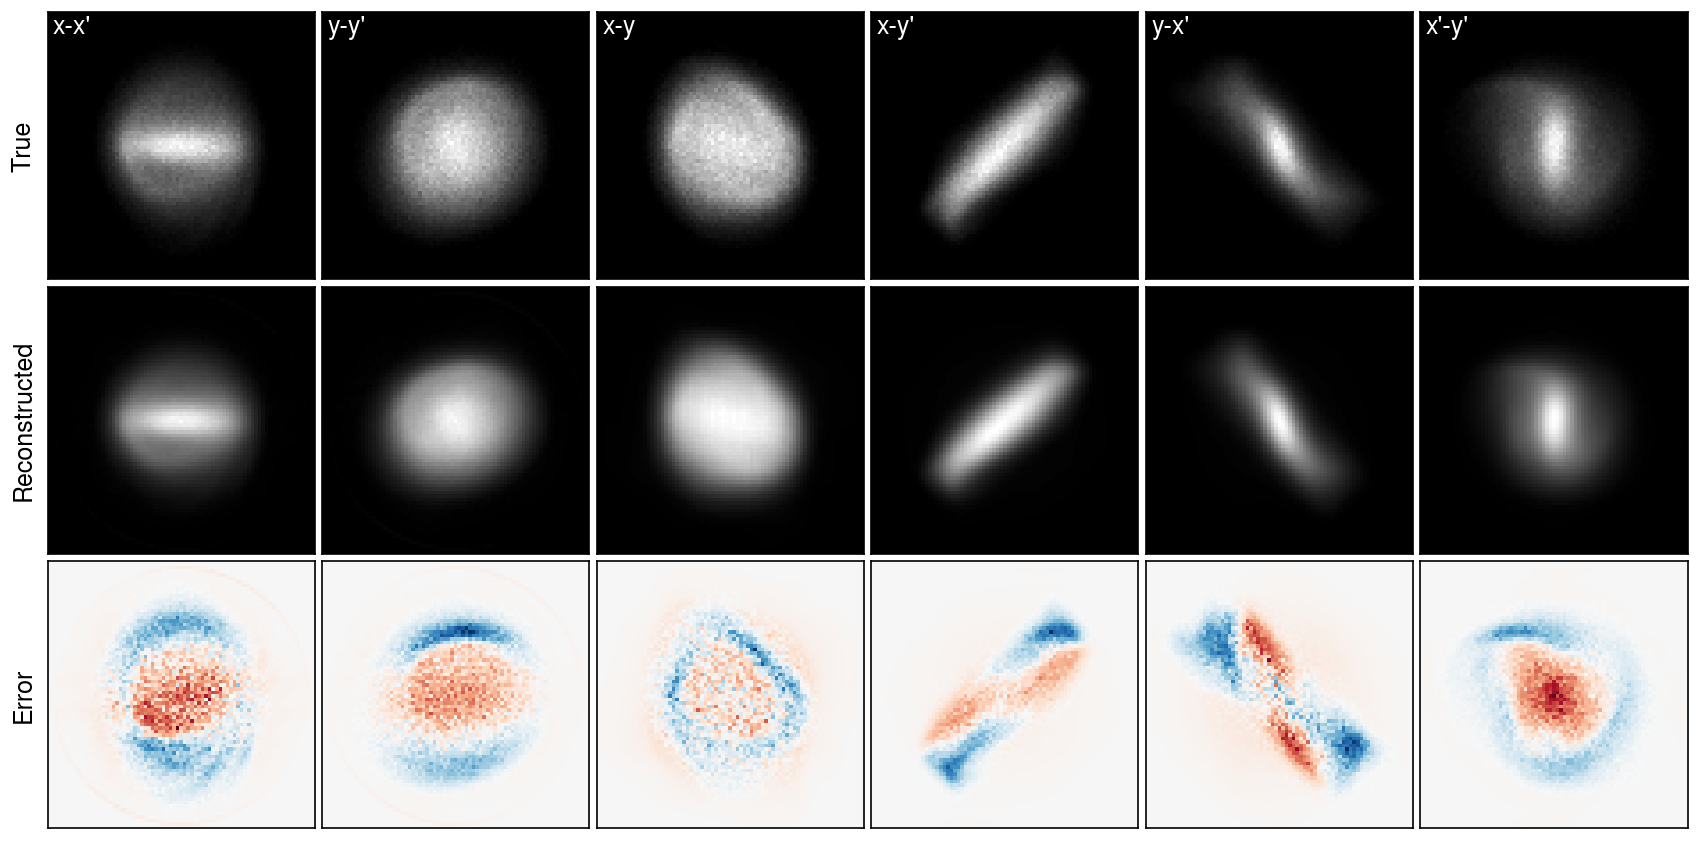

In [72]:
plot_kws = dict(cmap=cmap)
indices = [(0, 1), (2, 3), (0, 2), (0, 3), (2, 1), (1, 3)]
fig, axes = pplt.subplots(nrows=3, ncols=6, figwidth=8.5, sharex=False, sharey=False, space=0.3)
for col, (i, j) in enumerate(indices):
    _Z_true = rec.project(Z_true, [i, j])
    _Z = rec.project(Z_hock, [i, j])
    axes[0, col].pcolormesh(centers[i], centers[j], _Z_true.T, **plot_kws)
    axes[1, col].pcolormesh(centers[i], centers[j], _Z.T, **plot_kws)
    axes[2, col].pcolormesh(centers[i], centers[j], (_Z - _Z_true).T)
    axes[0, col].annotate('{}-{}'.format(labels[i], labels[j]),
                          xy=(0.02, 0.92), xycoords='axes fraction', color='white', 
                          fontsize='medium')
for ax, title in zip(axes[:, 0], ['True', 'Reconstructed', 'Error']):
    ax.set_ylabel(title)
axes.format(xticks=[], yticks=[])
plt.savefig('_output/tomo_sim_rec_hock_proj_2D_hor.png', dpi=500)
plt.show()

Transform to unnormalized phase space.

In [ ]:
# Zt = rec.transform(Z, V, centers, new_grid=None)

Study 2D reconstruction as function of number of angles and of the angular range.

In [14]:
from skimage.transform import radon, iradon_sart

i1, i2 = 2, 3
bins = 50
z_true, _, _ = np.histogram2d(Xn[:, i1], Xn[:, i2], bins, [limits[i1], limits[i2]], density=True)

n_proj_list = np.arange(3, 30)
max_angles = np.linspace(5., 180., 50, endpoint=False)
errors = np.zeros((len(n_proj_list), len(max_angles)))    
for i in trange(errors.shape[0]):
    for j in range(errors.shape[1]):
        angles = np.linspace(0., max_angles[j], n_proj_list[i])
        projections = radon(z_true, theta=angles, circle=True)
        z = iradon_sart(projections, theta=angles)
        z = iradon_sart(projections, theta=angles, image=z)
        z = rec.process(z, keep_positive=True, density=True, limits=[limits[i1], limits[i2]])
        # if i == 0:
        #     fig, axes = pplt.subplots(ncols=2)
        #     axes[0].pcolormesh(xedges, yedges, Z_true.T, cmap='viridis',)
        #     axes[1].pcolormesh(xedges, yedges, Z.T, cmap='viridis',)
        #     plt.show()
        errors[i, j] = np.sqrt(np.sum((z - z_true)**2))

  0%|                                                                                                   | 0/27 [00:00<?, ?it/s]/Users/austin/opt/anaconda3/lib/python3.9/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
100%|██████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:12<00:00,  2.22it/s]


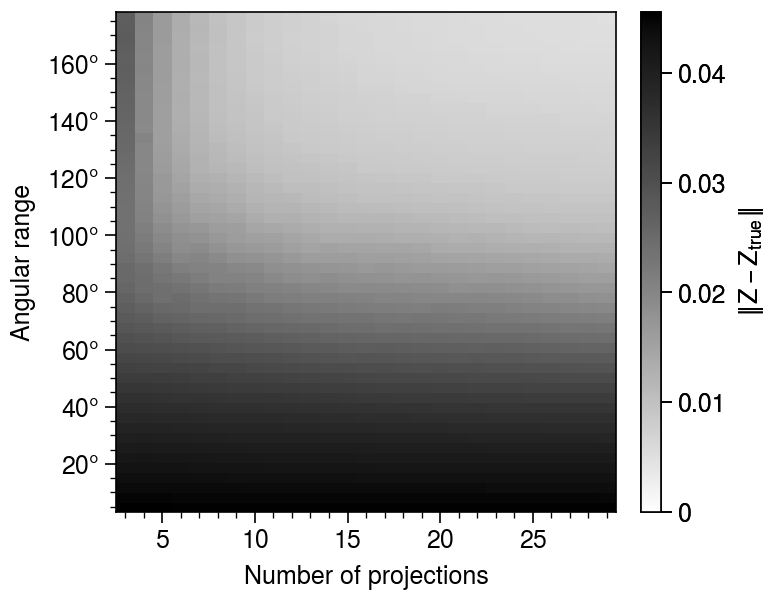

In [39]:
fig, ax = pplt.subplots()
ax.pcolormesh(
    n_proj_list, max_angles, errors.T, cmap=pplt.Colormap('mono'), 
    vmin=0,
    colorbar=True, 
    colorbar_kw=dict(label=r'$\Vert Z - Z_{true} \Vert$', width=0.1, space=1.0)
)
ax.format(yformatter='deg', ylabel='Angular range', xlabel='Number of projections')
plt.savefig('_output/tomo_sim_art2d.png', dpi=350)
plt.show()

## 4D ART 

In [86]:
n_bins = 50
Z_true2, edges = np.histogramdd(Xn, n_bins, limits, density=True)
centers = []
for _edges in edges:
    centers.append(0.5 * (_edges[:-1] + _edges[1:]))
rec_grid_centers = centers
screen_edges_x = edges[0]
screen_edges_y = edges[2]
bin_volume = rec.get_bin_volume(limits, n_bins)

In [87]:
K = 7 # number of angles in x dimension
L = 7 # number of angles in y dimension
muxx = np.linspace(0., np.pi, K, endpoint=False)
muyy = np.linspace(0., np.pi, L, endpoint=False)

xx_list, tmats_x = [], []
for mux in tqdm(muxx):
    Mx = utils.rotation_matrix(mux)
    xx_list.append(utils.apply(Mx, Xn[:, :2])[:, 0])
    tmats_x.append(Mx)

yy_list, tmats_y = [], []
for muy in tqdm(muyy):
    My = utils.rotation_matrix(muy)
    yy_list.append(utils.apply(My, Xn[:, 2:])[:, 0])
    tmats_y.append(My)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.05s/it]


In [88]:
sigma = 0.0 # Gaussian blur
projections, tmats = [], []
for k, xx in enumerate(tqdm(xx_list)):
    for l, yy in enumerate(yy_list):
        z, _, _ = np.histogram2d(xx, yy, n_bins, (limits[0], limits[2]))
        z = filters.gaussian(z, sigma)
        projections.append(z)
        M = np.zeros((4, 4))
        M[:2, :2] = tmats_x[k]
        M[2:, 2:] = tmats_y[l]
        tmats.append(M)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.26it/s]


In [89]:
Z = rec.art4D(projections, tmats, rec_grid_centers, (screen_edges_x, screen_edges_y))

Forming arrays.


 13%|█████████▋                                                                  | 751324/5910000 [00:00<00:04, 1255452.41it/s]


 44%|█████████████████████████████████                                          | 2612745/5930000 [00:02<00:02, 1222628.20it/s]


 77%|█████████████████████████████████████████████████████████▍                 | 4775771/6230000 [00:03<00:01, 1275375.57it/s]


  2%|█▎                                                                            | 99541/5930000 [00:00<00:05, 995368.23it/s]


 31%|███████████████████████▌                                                   | 1858504/5910000 [00:01<00:03, 1178394.67it/s]


 70%|████████████████████████████████████████████████████▍                      | 4133346/5910000 [00:03<00:01, 1272343.45it/s]


 93%|█████████████████████████████████████████████████████████████████████▍     | 5178175/5588496 [00:04<00:00, 1049793.60it/s]


 29%|█████████████████████▍                                                     | 1684927/5891088 [00:01<00:03, 1292690.84it/s]


 62%|██████████████████████████████████████████████▏                            | 3627702/5891088 [00:02<00:01, 1264884.19it/s]


  0%|                                                                                              | 0/5588496 [00:00<?, ?it/s]


 45%|█████████████████████████████████▍                                         | 2640645/5930000 [00:02<00:02, 1314559.89it/s]


 70%|████████████████████████████████████████████████████▍                      | 3920647/5607408 [00:03<00:01, 1235912.55it/s]


  8%|██████                                                                      | 467839/5911024 [00:00<00:04, 1206115.80it/s]


 38%|████████████████████████████▏                                              | 2217334/5911024 [00:01<00:02, 1275151.38it/s]


 79%|███████████████████████████████████████████████████████████▎               | 4446229/5626384 [00:03<00:00, 1244571.65it/s]


 16%|████████████▎                                                              | 1021597/6230000 [00:00<00:03, 1318027.15it/s]


 39%|█████████████████████████████▎                                              | 2272258/5891088 [00:02<00:03, 965392.07it/s]


 67%|█████████████████████████████████████████████████▉                         | 3937061/5911024 [00:03<00:01, 1233823.99it/s]


 91%|████████████████████████████████████████████████████████████████████▉       | 5631902/6210064 [00:04<00:00, 933281.20it/s]


  8%|██████                                                                      | 472880/5911024 [00:00<00:04, 1205180.20it/s]


 47%|███████████████████████████████████▌                                       | 2791900/5891088 [00:02<00:02, 1230341.30it/s]


 79%|███████████████████████████████████████████████████████████▏               | 4920376/6230000 [00:03<00:01, 1268986.02it/s]


  4%|██▊                                                                         | 222380/5911024 [00:00<00:05, 1132573.48it/s]


 39%|█████████████████████████████▍                                              | 2408631/6210064 [00:02<00:03, 972111.58it/s]


 53%|███████████████████████████████████████▋                                   | 3281597/6210064 [00:02<00:02, 1196337.20it/s]


 80%|████████████████████████████████████████████████████████████▌               | 4710734/5911024 [00:03<00:01, 963997.36it/s]


  4%|██▉                                                                         | 227825/5930000 [00:00<00:04, 1155674.01it/s]


 43%|████████████████████████████████▏                                          | 2403391/5607408 [00:01<00:02, 1279810.78it/s]


 86%|████████████████████████████████████████████████████████████████▊          | 4860140/5626384 [00:03<00:00, 1248901.75it/s]


  4%|██▊                                                                         | 219580/5911024 [00:00<00:05, 1113535.34it/s]


 42%|███████████████████████████████▋                                           | 2380621/5626384 [00:01<00:02, 1291106.33it/s]


 82%|█████████████████████████████████████████████████████████████▌             | 4605850/5607408 [00:03<00:00, 1269452.19it/s]


 14%|██████████▌                                                                  | 766604/5588496 [00:00<00:04, 968711.44it/s]


 55%|████████████████████████████████████████▉                                  | 3059809/5607408 [00:02<00:02, 1212277.31it/s]


 79%|████████████████████████████████████████████████████████████▏               | 4669785/5891088 [00:04<00:01, 945110.83it/s]


 11%|████████                                                                    | 593436/5607408 [00:00<00:03, 1474283.56it/s]


 58%|███████████████████████████████████████████▋                               | 3256709/5588496 [00:02<00:01, 1441844.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 49/49 [20:44<00:00, 25.40s/it]


Creating sparse matrix P.
Done. t = 279.1439960002899
Solving linear system.
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 122500 rows and 6250000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =     1000
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.112e+05  2.112e+05    1.0e+00  1.2e-03
     1  2.23850e-02   1.396e+05  1.396e+05    6.6e-01  4.5e-01   3.3e+02  1.0e+00
     2 -8.02458e-02   8.523e+04  8.523e+04    4.0e-01  2.3e-01   4.0e+02  2.6e+00
     3  3.64187e-02   4.791e+04  4.791e+04    2.3e-01  2.3e-01   4.2e+02  5.0e+00
     4 -6.49040e-03   3.294e+04  3.294e+04    1.6e-01  1.8e-01   4.5e+02  6.6e+00
     5 -2.40757e-02   2.232e+04  2.232e+04    1.1e-01  1.9e-01   4.7e+02  8.6e+00
     6 -1.69655e-02   1.385e+04  1.385e+04    6.6e-02  1.5e-01   4.9e+02  1.1e+01
     7 -1.44865e-02   1.120e+04  1

In [90]:
Z = rec.process(Z, keep_positive=True, density=True, limits=limits)

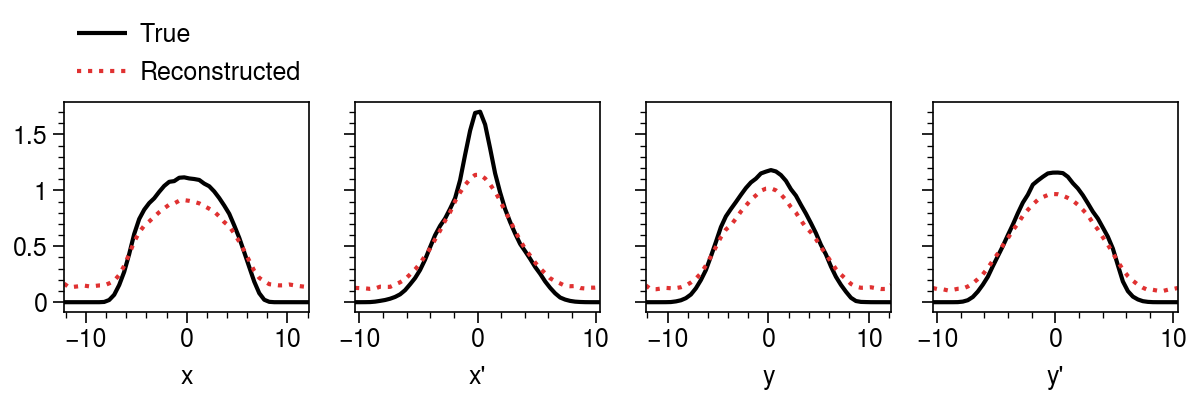

In [91]:
fig, axes = pplt.subplots(ncols=4, figsize=(6, 2), spanx=False)
labels = ["x", "x'", "y", "y'"]
for i in range(4):
    axes[i].plot(centers[i], rec.project(Z_true2, i), color='black', label='True')
    axes[i].plot(centers[i], rec.project(Z, i), color='red8', ls='dotted', label='Reconstructed')
    axes[i].set_xlabel(labels[i])
axes[0].legend(loc=(0.0, 1.02), framealpha=0.0, ncol=1);
plt.savefig('_output/tomo_sim_rec_art_proj1D.png', dpi=350)
plt.show()

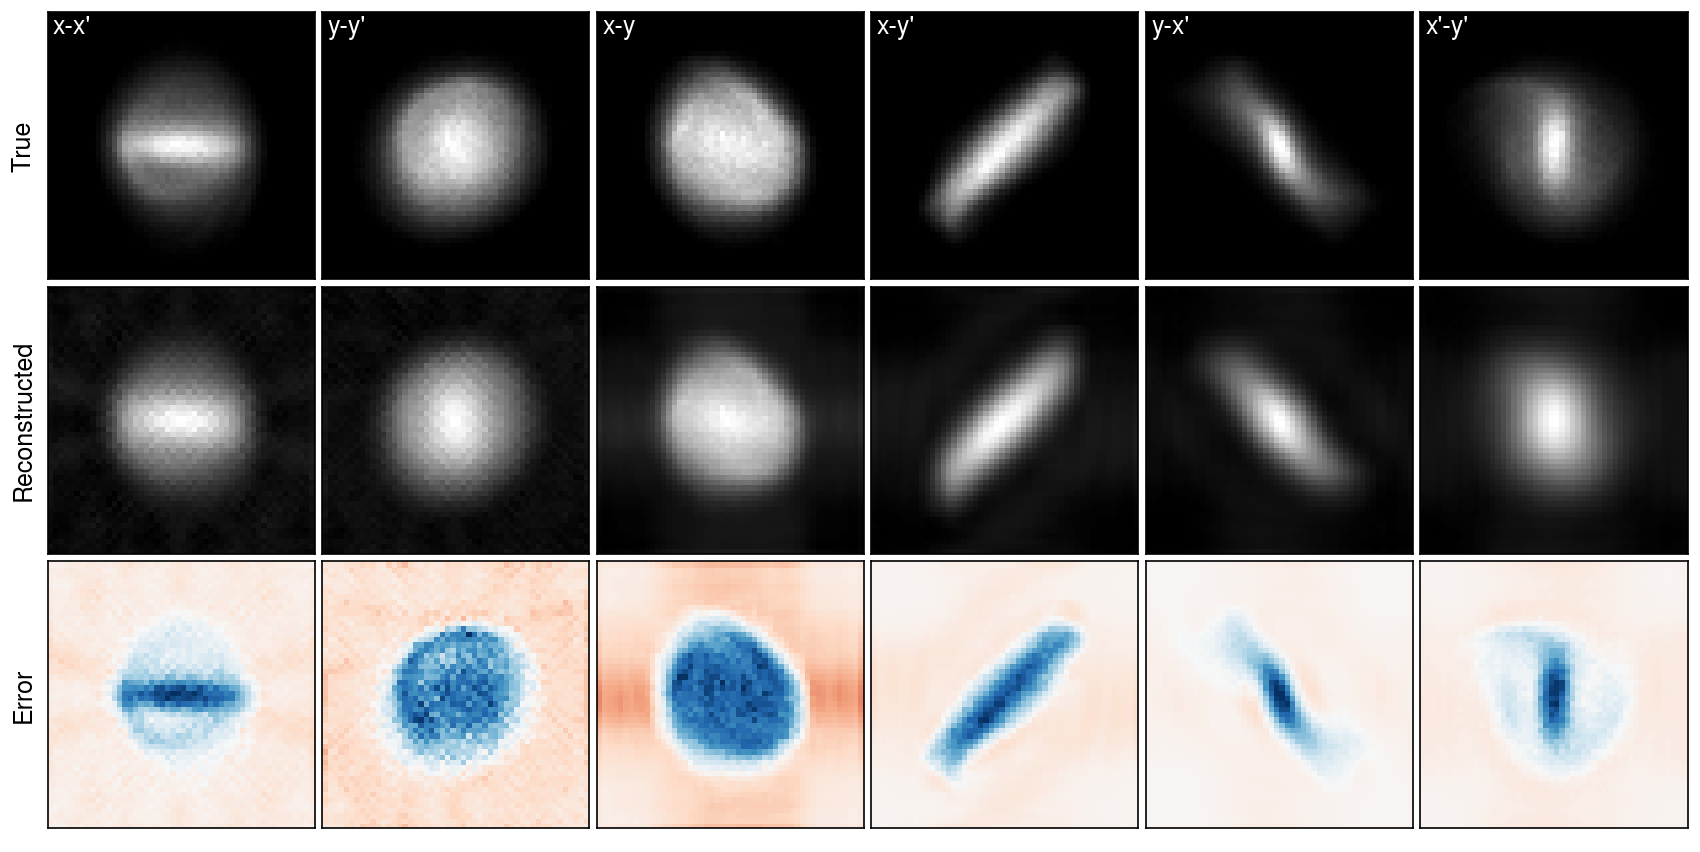

In [92]:
plot_kws = dict(cmap=cmap)
indices = [(0, 1), (2, 3), (0, 2), (0, 3), (2, 1), (1, 3)]
fig, axes = pplt.subplots(nrows=3, ncols=6, figwidth=8.5, sharex=False, sharey=False, space=0.3)
for col, (i, j) in enumerate(indices):
    _Z_true = rec.project(Z_true2, [i, j])
    _Z = rec.project(Z, [i, j])
    axes[0, col].pcolormesh(centers[i], centers[j], _Z_true.T, **plot_kws)
    axes[1, col].pcolormesh(centers[i], centers[j], _Z.T, **plot_kws)
    axes[2, col].pcolormesh(centers[i], centers[j], (_Z - _Z_true).T)
    axes[0, col].annotate('{}-{}'.format(labels[i], labels[j]),
                          xy=(0.02, 0.92), xycoords='axes fraction', color='white', 
                          fontsize='medium')
for ax, title in zip(axes[:, 0], ['True', 'Reconstructed', 'Error']):
    ax.set_ylabel(title)
axes.format(xticks=[], yticks=[])
plt.savefig('_output/tomo_sim_rec_art_proj_2D_hor.png', dpi=500)
plt.show()

In [ ]:
plot_kws = dict(cmap='mono_r', robust=False)
indices = [(0, 1), (2, 3), (0, 2), (0, 3), (2, 1), (1, 3)]
fig, axes = pplt.subplots(nrows=6, ncols=3, figsize=(5.0, 8.5), 
                          sharex=False, sharey=False, space=0.5)
for row, (i, j) in enumerate(indices):
    _Z_true = rec.project(Z_true, [i, j])
    _Z = rec.project(Z, [i, j])
    _Z_true2 = rec.project(Z_true2, [i, j])
    axes[row, 0].pcolormesh(_Z_true.T, **plot_kws)
    axes[row, 1].pcolormesh(centers[i], centers[j], _Z.T, **plot_kws)
    axes[row, 2].pcolormesh(centers[i], centers[j], (_Z - _Z_true2).T, 
                            colorbar=True, 
                            colorbar_kw=dict(width=0.075, space=1.0, ticklabelsize='small')
                           )
    axes[row, 0].annotate('{}-{}'.format(labels[i], labels[j]),
                          xy=(0.02, 0.92), xycoords='axes fraction', color='white', 
                          fontsize='medium')
for ax, title in zip(axes[0, :], ['True', 'Reconstructed', 'Error']):
    ax.set_title(title)
axes.format(xticks=[], yticks=[])
plt.savefig('_output/tomo_sim_rec_art_proj2D.png', dpi=350)
plt.show()

## Particle-based 